spotify_run20.csv error: Expected 45 fields in line 8, saw 47
youtube_music_run16.csv error: Expected 45 fields in line 7, saw 47


/tmp/ipython-input-1037/365944914.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Saved: music_app_CPU_%.png


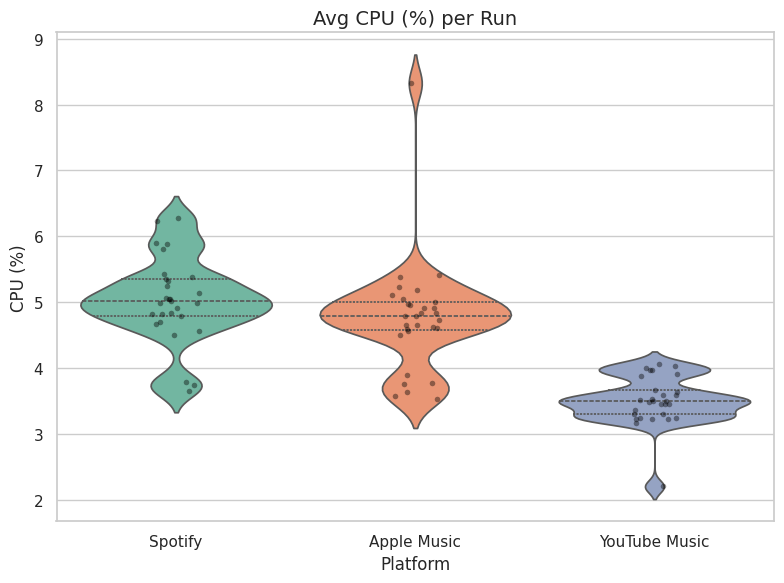

/tmp/ipython-input-1037/365944914.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Saved: music_app_RAM_GB.png


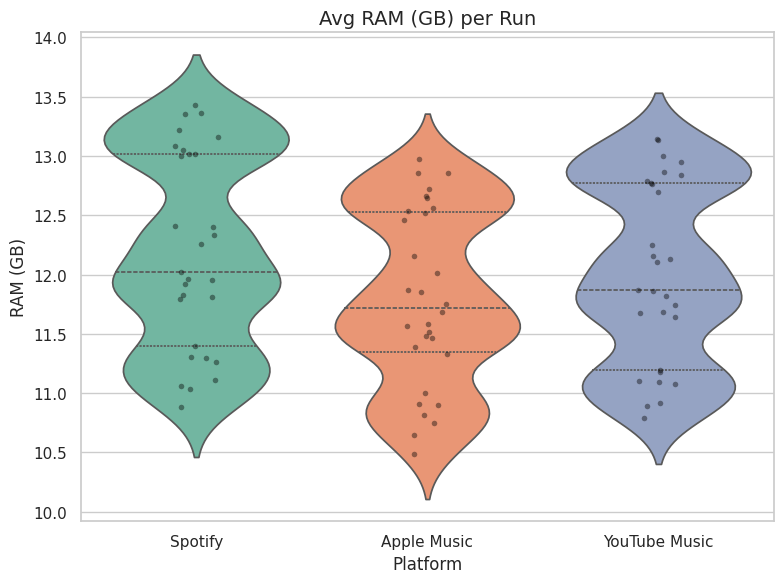

/tmp/ipython-input-1037/365944914.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Saved: music_app_Energy_J.png


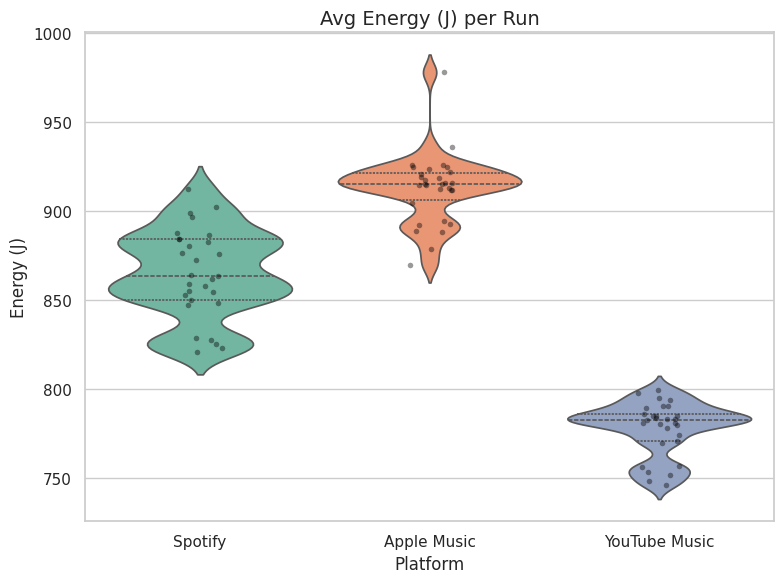


 Means
                CPU (%)   RAM (GB)  Energy (J)
Platform                                      
Apple Music    4.759331  11.798454  912.859079
Spotify        5.031411  12.197581  864.838607
YouTube Music  3.504345  12.004902  777.648702
CPU (%):
  F-statistic: 44.3014
  p-value:     6.5938e-14
RAM (GB):
  F-statistic: 1.9224
  p-value:     1.5256e-01
Energy (J):
  F-statistic: 331.7976
  p-value:     6.9953e-41


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import numpy as np

apps = {
    'Spotify': 'spotify',
    'Apple Music': 'apple_music',
    'YouTube Music': 'youtube_music'
}
num_runs = 30
summary_list = []

for display_name, file_prefix in apps.items():
    for run in range(1, num_runs + 1):
        file_name = f"{file_prefix}_run{run:02d}.csv"

        if not os.path.exists(file_name):
            continue

        try:
            df = pd.read_csv(file_name, engine='python')

            df.columns = df.columns.str.strip()
            df = df.rename(columns={'elta': 'Delta'})

            if 'Time' in df.columns:
              df = df.sort_values('Time')

              time_s = (df['Time'] - df['Time'].iloc[0]) / 1000.0

            cpu_cols = [c for c in df.columns if 'CPU_USAGE' in c]
            if cpu_cols:
                avg_cpu = df[cpu_cols].mean(axis=1).mean()
            else:
                avg_cpu = None

            if 'USED_MEMORY' in df.columns:
                avg_mem = df['USED_MEMORY'].mean() / (1024**3)
            else:
                avg_mem = None

            pwr_col = [c for c in df.columns if 'POWER' in c.upper() or 'SYSTEM_POWER' in c.upper()]
            if pwr_col and 'Time' in df.columns:
                # time_s = df['Time'] / 1000.0
                power_w = df[pwr_col[0]]

                total_energy_j = np.trapezoid(power_w, x=time_s)
            else:
                total_energy_j = None


            summary_list.append({
              'Platform': display_name,
              'Run': run,
              'CPU (%)': avg_cpu,
              'RAM (GB)': avg_mem,
              'Energy (J)': total_energy_j
          })

        except Exception as e:
            print(f"{file_name} error: {e}")

df_final = pd.DataFrame(summary_list)

sns.set_theme(style="whitegrid")

metrics = ['CPU (%)', 'RAM (GB)', 'Energy (J)']

for metric in metrics:
    plt.figure(figsize=(8, 6))

    sns.violinplot(
        data=df_final,
        x='Platform',
        y=metric,
        palette="Set2",
        inner="quartile",
        bw_adjust=.5
    )

    sns.stripplot(
        data=df_final,
        x='Platform',
        y=metric,
        color='black',
        alpha=0.4,
        size=4
    )

    plt.title(f'Avg {metric} per Run', fontsize=14)

    safe_metric_name = metric.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")
    file_name = f'music_app_{safe_metric_name}.png'

    plt.tight_layout()
    plt.savefig(file_name, dpi=300)
    print(f"Saved: {file_name}")

    plt.show()
    plt.close()

print("\n Means")
print(df_final.groupby('Platform')[metrics].mean())

df_clean = df_final[df_final['Energy (J)'] > 100]

for metric in metrics:
    groups = [df_clean[df_clean['Platform'] == app][metric].dropna() for app in df_clean['Platform'].unique()]

    f_stat, p_val = stats.f_oneway(*groups)

    print(f"{metric}:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  p-value:     {p_val:.4e}")